# ADP - Approximate Dynamic Programming

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from numpy.random import random_sample
from scipy.special import softmax
import time
import matplotlib.pyplot as plt
import sys
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Setup

In [258]:
array = np.array((0,0,1,0)).reshape((4,1))
Xref0 = 0.001518 * array
Xref2 = -0.022689 * array
Xref4 = -0.023736 * array
Xref6 = -0.051836 * array
Xref8 = -0.06526 * array
Xref10 = -0.075049 * array
# Xrefs = [Xref0,Xref2,Xref4,Xref6,Xref8,Xref10]
# Xrefs = [Xref0,Xref4,Xref6,Xref10]
Xrefs = [Xref0, Xref4, Xref8]

In [259]:
# Next State Functions
def f(A,B,K,X):
    u = K @ X
    return A@X - B*u, u

In [260]:
ncon = len(Xrefs)
nstates = 4
seq_len = 300

### Experimental Data Points

In [276]:
data0 = np.array(np.loadtxt('weight0.txt', delimiter=',')) #+ Xref0.T)
data2 = np.array(np.loadtxt('weight2.txt', delimiter=',')) #+ Xref2.T)
data4 = np.array(np.loadtxt('weight4.txt', delimiter=',')) #+ Xref4.T)
data6 = np.array(np.loadtxt('weight6.txt', delimiter=',')) #+ Xref6.T)
data8 = np.array(np.loadtxt('weight8.txt', delimiter=',')) #+ Xref8.T)
data10 = np.array(np.loadtxt('weight10.txt',delimiter=',')) #+ Xref10.T)

In [277]:
print(data0.shape)

(9222, 4)


In [278]:
data0_ = np.array(np.loadtxt('weight0_switching_K.txt',delimiter=','))
data4_ = np.array(np.loadtxt('weight4_switching_K.txt',delimiter=','))
data8_ = np.array(np.loadtxt('weight8_switching_K.txt',delimiter=','))

In [279]:
print(data0.shape)

(9222, 4)


In [280]:
# data_list = [np.vstack((data0[:400],data0[1400:])),np.vstack((data4[:400],data4[1400:])),np.vstack((data8[:400],data8[1400:]))]
# data_list = [np.array(data0), np.array(data2), np.array(data4), np.array(data6), np.array(data8), np.array(data10)]
# data_list = [np.vstack((data0[:400],data0[1400:])),np.vstack((data2[:400],data2[1400:])),np.vstack((data4[:400],data4[1400:])),np.vstack((data6[:400],data6[1400:])),np.vstack((data8[:400],data8[1400:])),np.vstack((data10[:400],data10[1400:]))]
data_list = [data0, data0_, data4, data4_, data8, data8_]

In [354]:
val_list = [data0[400:1400], data4[400:1400], data8[400:1400]]
# val_list = [data0[400:1400], data2[400:1400], data4[400:1400], data6[400:1400], data8[400:1400], data10[400:1400]]

In [355]:
val_seq_list = []
val_labels = []
label = 0
for v in val_list:
    for i in range(v.shape[0]-seq_len):
        val_seq_list.append(v[i:i+seq_len].T.reshape((1,nstates,seq_len)))
        val_labels.append(label)
    label += 1
assert(len(val_seq_list) == len(val_labels))
val_seq = np.concatenate(val_seq_list, axis=0)

In [288]:
for i in range(len(data_list)):
    print(i, data_list[i].shape)

0 (9222, 4)
1 (9131, 4)
2 (9192, 4)
3 (9717, 4)
4 (9347, 4)
5 (9226, 4)


In [281]:
data_seq_list = []
labels = []
label = 0
idx = 1
for d in data_list:
    for i in range(d.shape[0]-seq_len):
        data_seq_list.append(d[i:i+seq_len].T.reshape((1,nstates,seq_len)))
        labels.append(label)
    if idx %2 == 0:
        label += 1
    idx += 1
assert(len(data_seq_list) == len(labels))
data_seq = np.concatenate(data_seq_list, axis=0)

In [303]:
data_train, data_val, labels_train, labels_val = train_test_split(data_seq, labels, test_size=0.3)

In [304]:
print(len(labels))

54035


In [305]:
print(data_seq.shape)

(54035, 4, 300)


In [306]:
print(data_train.shape)

(37824, 4, 300)


In [307]:
class StatesDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.from_numpy(data).type('torch.FloatTensor')
        self.labels = labels
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        return self.data[index], self.labels[index]

In [308]:
trainset = StatesDataset(data_train, labels_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=0, drop_last=False)

valset = StatesDataset(data_val, labels_val)
valloader = DataLoader(valset, batch_size=128, shuffle=True, num_workers=0, drop_last=False)

## The Model - Curve to Fit u*(X(k))

In [309]:
class Model(nn.Module):
    def __init__(self, nstates, noutputs):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(nstates, 16, bias=False)
        self.conv1 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(32)
        self.drop1 = nn.Dropout(p=0)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.fc2 = nn.Linear(64, noutputs, bias=False)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.conv1(out.unsqueeze(2))
        out = self.bn1(out)
        out = self.drop1(out)
        out = self.conv2(out)
        out = self.fc2(out.squeeze(2))
        return out

In [310]:
class ResBlock2(nn.Module):
    def __init__(self, channel_size, stride=1):
        super(ResBlock2, self).__init__()
        self.conv1 = nn.Conv2d(channel_size, 4*channel_size, kernel_size=(2,5), stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(4*channel_size)
        self.conv2 = nn.Conv2d(4*channel_size, channel_size, kernel_size=1, stride=stride, bias=False)
        self.bn2 = nn.BatchNorm2d(channel_size)
        self.shortcut = nn.Conv2d(channel_size, channel_size, kernel_size=(2,5), stride=stride, bias=False)
        
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out1 = self.shortcut(x)
        out = F.relu(out)
        return out

In [311]:
class ModelCONV2D(nn.Module):
    def __init__(self, nstates, noutputs, seq_len):
        super(ModelCONV2D, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(2,20), stride=1)
        self.bn1 = nn.BatchNorm2d(8, momentum=0.1)
        self.relu1 = nn.ReLU(inplace=True)
        self.drop1 = nn.Dropout(p=0.3)
        
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(2,20), stride=1)
        self.bn2 = nn.BatchNorm2d(16, momentum=0.1)
        self.relu2 = nn.ReLU(inplace=True)
        self.drop2 = nn.Dropout(p=0.3)
        
#         self.conv3 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(2,5), stride=1)
#         self.bn3 = nn.BatchNorm2d(16, momentum=0.1)
#         self.relu3 = nn.ReLU(inplace=True)
#         self.drop3 = nn.Dropout(p=0.2)
        
        self.flat = nn.Flatten()
#         self.fc1 = nn.Linear(16*(nstates-2)*(seq_len-8), noutputs*64)
        self.fc1 = nn.Linear(16*(nstates-2)*(seq_len-38), noutputs*64)
        self.fc2 = nn.Linear(noutputs*64, noutputs)
        
    def forward(self, x):
        x = x.unsqueeze(1)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.drop1(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.drop2(out)
        
#         out = self.conv3(out)
#         out = self.bn3(out)
#         out = self.relu3(out)
#         out = self.drop3(out)
        
        out = self.flat(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [312]:
class ModelLSTM(nn.Module):
    def __init__(self, nstates, noutputs):
        super(ModelLSTM, self).__init__()
        self.fc1 = nn.Linear(nstates, 8, bias=False)
        self.lstm = nn.LSTM(input_size=8, hidden_size=64, num_layers=2, batch_first=True)
        self.fc2 = nn.Linear(64, noutputs, bias=False)
        
    def forward(self, x):
        x = x.permute(0,2,1) # (nsamples, nseq, 4)
        out = self.fc1(x) # (nsamples, nseq, 8)
        out = self.lstm(out)[0] # (nsamples, nseq, 64)
        out = self.fc2(out) # (nsamples, nseq, noutputs)
        return out

## Offline Training

In [313]:
def train(model, trainloader, valloader, criterion, optimizer, nepochs):
    model.train()
    
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    for epoch in range(nepochs):
        model.train()
        start = time.time()
        
        batch_loss = 0.0
        numbatches = 0
        batch_acc = []
        l0 = 0
        l1 = 0
        l2 = 0
        l3 = 0
        l4 = 0
        l5 = 0
        for batch_num, (data, labels) in enumerate(trainloader):
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            
            out = model(data)
            pred = torch.argmax(out, dim=1)

    #         print('pred',pred)
    #         print('label',label)
            
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            
            batch_loss += loss.item() #/ len(labels)
            numbatches += 1
            batch_acc.append(np.sum([pred.detach().cpu().numpy() == labels.detach().cpu().numpy()]) / len(labels))
            
            l0 += np.sum([labels.detach().numpy() == 0])
            l1 += np.sum([labels.detach().numpy() == 1])
            l2 += np.sum([labels.detach().numpy() == 2])
            l3 += np.sum([labels.detach().numpy() == 3])
            l4 += np.sum([labels.detach().numpy() == 4])
            l5 += np.sum([labels.detach().numpy() == 5])
            
            del data
            del labels
            del out
            del pred
            del loss
        
        val_loss, val_acc = validate(model, valloader, criterion)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
        
        train_loss_list.append(batch_loss/numbatches)
        train_acc_list.append(np.mean(batch_acc) * 100)
        
        end = time.time()
        minutes = (end-start) // 60
        sec = (end-start) % 60
        print("Epoch: %d, Run Time: %d min, %d sec" %(epoch+1, minutes, sec))
        print('Train Loss:' + str(train_loss_list[-1]) + '\t Train Accuracy:' + str(round(train_acc_list[-1],2)) + '%')
        print('Val Loss:' + str(val_loss) + '\t Val Accuracy:' + str(round(val_acc,2)) + '%')
        print('Label 0:' + str(l0) + ' Label 1:' + str(l1) + ' Label 2:' + str(l2) + ' Label 3:' + str(l3) + ' Label 4:' + str(l4) + ' Label 5:' + str(l5))
        print('=========================================')
    
    return train_loss_list, train_acc_list, val_loss_list, val_acc_list

In [314]:
def validate(model, valloader, criterion):
    model.eval()
    val_loss = []
    val_acc = []
    for batch_num, (data, labels) in enumerate(valloader):
        data, labels = data.to(device), labels.to(device)
        out = model(data)
        pred = torch.argmax(out, dim=1)

        loss = criterion(out, labels)
        val_loss.append(loss.item())
        val_acc.append(np.sum([pred.detach().cpu().numpy() == labels.detach().cpu().numpy()])/len(labels))
#         print('pred', pred)
#         print('labels', labels)

        del data
        del labels
        del out
        del pred
        del loss
    
    return np.mean(val_loss), np.mean(val_acc) * 100

In [343]:
model = ModelCONV2D(nstates=4, noutputs=len(Xrefs), seq_len=seq_len)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, weight_decay=5e-5, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-5)

In [344]:
nepochs = 35


In [345]:
train_loss, train_acc, val_loss, val_acc = train(model, trainloader, valloader, criterion, optimizer, nepochs)

Epoch: 1, Run Time: 0 min, 37 sec
Train Loss:1.1500714616598309	 Train Accuracy:48.75%
Val Loss:0.7115206906175989	 Val Accuracy:63.92%
Label 0:12529 Label 1:12802 Label 2:12493 Label 3:0 Label 4:0 Label 5:0
Epoch: 2, Run Time: 0 min, 38 sec
Train Loss:0.621692943915322	 Train Accuracy:73.33%
Val Loss:0.41064528874524936	 Val Accuracy:84.89%
Label 0:12529 Label 1:12802 Label 2:12493 Label 3:0 Label 4:0 Label 5:0
Epoch: 3, Run Time: 0 min, 41 sec
Train Loss:0.4751822489338952	 Train Accuracy:81.01%
Val Loss:0.28002142741924196	 Val Accuracy:91.19%
Label 0:12529 Label 1:12802 Label 2:12493 Label 3:0 Label 4:0 Label 5:0
Epoch: 4, Run Time: 0 min, 38 sec
Train Loss:0.39185929404118575	 Train Accuracy:84.61%
Val Loss:0.33425975197882163	 Val Accuracy:85.51%
Label 0:12529 Label 1:12802 Label 2:12493 Label 3:0 Label 4:0 Label 5:0
Epoch: 5, Run Time: 0 min, 37 sec
Train Loss:0.3195632062348965	 Train Accuracy:87.67%
Val Loss:0.18864717451840873	 Val Accuracy:93.42%
Label 0:12529 Label 1:12802 

Epoch: 34, Run Time: 0 min, 36 sec
Train Loss:0.08439311091599332	 Train Accuracy:96.89%
Val Loss:0.05212613206914091	 Val Accuracy:98.1%
Label 0:12529 Label 1:12802 Label 2:12493 Label 3:0 Label 4:0 Label 5:0
Epoch: 35, Run Time: 0 min, 36 sec
Train Loss:0.07165717524224641	 Train Accuracy:97.38%
Val Loss:0.09872615032308683	 Val Accuracy:95.34%
Label 0:12529 Label 1:12802 Label 2:12493 Label 3:0 Label 4:0 Label 5:0


model_1: 6 outputs (0,2,4,6,8,10), 300 seq_len, 3 Conv2d (1,4,8,16), 30 epochs, 92.9% train acc, 94.16% val acc <br>
model_2: 6 outputs (0,2,4,6,8,10), 300 seq_len, 2 Conv2d (1,8,16), 30 epochs, 92.62 train acc, 97.56 val acc <br>
model_3: 4 outputs (0,4,8,10), 300 seq_len, 2 Conv2d (1,8,16), 40 epochs, 94.43% train acc, 97.65% val acc <br>
model_4: 6 outputs (0,2,4,6,8,10), 300 seq_len, 2 Conv2d (1,8,16), 50 epochs, 94.82% train acc, 88.96% val acc <br>
model_6: 3 outputs (0,4,8), 300 seq_len, 2 Conv2d (1,8,16), 10 epochs, 99.98% train acc, 100% val acc <br>
model_7: 6 outputs (0,2,4,6,8,10), 300 seq_len, 2 Conv2d (1,8,16), 10 epochs, 95.94% train acc, 97.2% val acc <br>
model_8: 6 outputs (0,2,4,6,8,20), 300 seq_len, 2 Conv2d (1,8,16) kernel(2,30), 10 epochs, 99.9% train, 100% val <br>
model_9: switching_K, 3 outputs(0,4,8), 300 seq_len, 2 Conv2d(1,8,16), kernel(2,20), 35 epochs, 97.64% train, 98.95% val <br> 

In [328]:
torch.save(model.state_dict(), './model_9.pt', _use_new_zipfile_serialization=False)

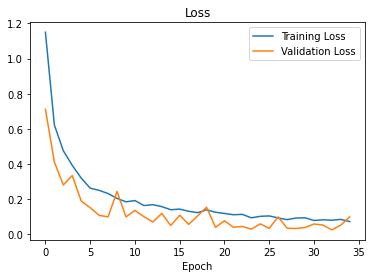

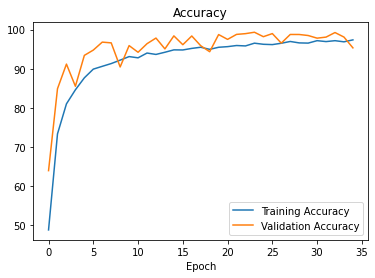

In [346]:
x = np.arange(nepochs)
plt.plot(x,train_loss, label='Training Loss')
plt.plot(x,val_loss, label = 'Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
plt.plot(x,train_acc, label='Training Accuracy')
plt.plot(x,val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [329]:
def sim_val(model, val_seq, val_labels):
    pred = []
    data = torch.from_numpy(val_seq).type('torch.FloatTensor')
    out = model(data)
    pred = torch.argmax(out, dim=1).detach().numpy()
    return pred 

In [356]:
# noise = np.random.normal(0,0.001,val_seq.shape)
# val_noise = val_seq + noise
model_test = ModelCONV2D(nstates=4, noutputs=3, seq_len=seq_len)
model_test.load_state_dict(torch.load('model_9.pt'))
pred = sim_val(model, val_seq, val_labels)
accuracy = sum(pred == np.array(val_labels))/len(val_labels)
# for i in range(len(pred)/5):
#     pred[]

In [357]:
print(accuracy)

1.0


In [358]:
print(val_noise.shape)

(3000, 4, 500)


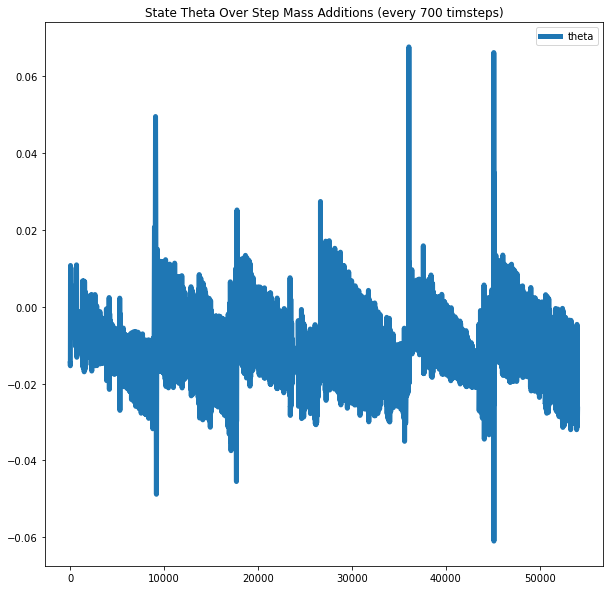

In [359]:
T = np.arange(len(labels))
plt.figure(figsize=(10,10))
# plt.plot(T,val_seq[:,0,0],label='x')
# plt.plot(T,val_seq[:,1,0],label='xdot')
plt.plot(T,data_seq[:,2,0],linewidth=5,label='theta')
# plt.plot(T,val_seq[:,3,0],label='thetadot')
plt.legend()
plt.title('State Theta Over Step Mass Additions (every 700 timsteps)')
plt.show()

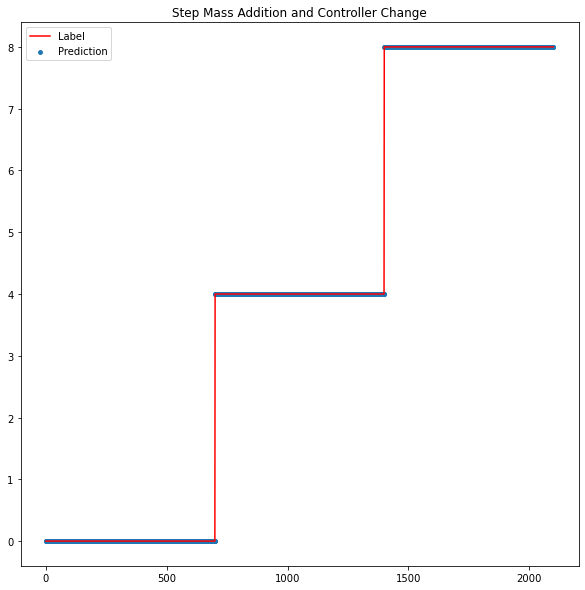

In [361]:
plt.figure(figsize=(10,10))
plt.plot(np.arange(len(val_labels)), [v*4 for v in val_labels], 'r', label='Label')
plt.scatter(np.arange(len(val_labels)), np.array([p*4 for p in pred]), s=15, label='Prediction')
plt.legend()
plt.title('Step Mass Addition and Controller Change')
plt.show()

In [220]:
def get_pred(model, data, labels):
    model.eval()
    data = torch.from_numpy(data).type('torch.FloatTensor')
    
    out = model(data)
    pred = torch.argmax(out, dim=1)
    
    accuracy = np.sum([pred.detach().numpy() == np.array(labels)])/len(labels) * 100
    
    print(str(accuracy) + '% accuracy over ' + str(len(labels)) + ' samples.')
    
    return accuracy

In [221]:
starttime = time.time()

acc = get_pred(model_test, data_seq, labels)
endtime = time.time()
minutes = (endtime-starttime) // 60
sec = (endtime-starttime) % 60
sampletime = float((endtime-starttime) * 1000) / len(labels)
print("Run Time: %d min %d sec. %f millisec per sample." %(minutes, sec, sampletime))

100.0% accuracy over 52621 samples.
Run Time: 0 min 38 sec. 0.733124 millisec per sample.
